In [1]:
import numpy as np
import pandas as pd

from scikits.odes import dae
from scikits.odes.sundials import ida

import matplotlib.pyplot as plt
%matplotlib notebook

In [127]:
class Problem():
    def __init__(self, theta, inj, ref, time):
        x0, v0, self.c = self.get_initial_values(P0=1997.9999999936396,
                                                 Q0=967.9249699065775,
                                                 V0=1.0,
                                                 angle0=0.494677176989154,
                                                 theta0=theta)
        self.x0 = np.hstack([x0, v0])
        self.xp0 = np.zeros(16)
        self.theta = theta
        self.inj = inj
        self.curinj = self.inj[0]
        self.ref = ref
        self.time = time
        
    def set_res(self, resfunction):
        self.res = resfuntion
        
    def set_jac(self, jacfunction):
        self.jac = jacfunction
    
    @classmethod
    def get_initial_values(cls, P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
        """
        Initializes generator state vector `x` and network terminal variables vector `V`
        in machine base from given power flow values in system base and angle in radians.
        """

        # unpack parameters guess

        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0

        # define transforms

        # vf_MB = vf * Vb / Vn
        wb = 2 * np.pi * fn
        S_SBtoMB = Sb / Sn
        V_MBtoSB = Vn / Vb
        I_MBtoSB = Sn * Vb / (Sb * Vn)
        Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)

        # initialize stator quantitites

        p0 = P0 / Sb
        q0 = Q0 / Sb
        Vt0 = V0 * np.exp(1j * angle0)
        S0 = p0 - 1j * q0
        I0 = S0 / Vt0.conjugate()
        vrr0 = Vt0.real
        vi0 = Vt0.imag
        ir0 = -I0.real
        ii0 = -I0.imag

        # initialize DQ-quantities

        w0 = 1
        delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)

        Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
        Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))

        vd0 = Vdq0.real
        vq0 = Vdq0.imag
        id0 = Idq0.real
        iq0 = Idq0.imag
        
        # constants

        pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
        vsmin, vsmax = -0.2, 0.2
        vfmin, vfmax = -6.4, 7

        # initialize order 3

        e1q0 = vq0 + ra * iq0 + x1d * id0
        
        # initialize PSS

        v20 = Tw * Kw * ws * (pm - (vq0 + ra * iq0) * iq0 - \
                              (vd0 + ra * id0) * id0 - KD * (w0 / ws - 1)) / (2 * H)

        # initialize AVR

        v = np.abs(Vt0)
        vref = v
        vs0 = Tpss1 * (Kw * ws * (pm - (vq0 + ra * iq0) * iq0 - (vd0 + ra * id0) * id0 \
                                  - KD * (w0 / ws - 1)) / (2 * H) - v20 / Tw) + v20
        vm0 = v
        vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
        vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)

        # pack values

        x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
        V = np.array([vd0, vq0, id0, iq0, vrr0, vi0, ir0, ii0])
        c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb])

        return x, V, c

class RHS(ida.IDA_RhsFunction):
    def set_problem(self, problem):
        self.problem = problem
        
    def evaluate(self, t, x, xdot, result, userdata):
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = self.problem.c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.problem.theta
        delta, w, v2, vs, vm, vr, vf, e1q, vd, vq, id, iq, vrr, vi, ir, ii = x
        ddelta, dw, dv2, dvs, dvm, dvr, dvf, de1q, dvd, dvq, did, diq, dvrr, dvi, dir, dii = xdot
        p, q = self.problem.curinj
        vt = np.sqrt(vd ** 2 + vq ** 2)

        result[0] = wb * (w - ws) - ddelta
        result[1] = ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - dw
        result[2] = Kw * ws * (pm - (vq + ra * iq) * iq - \
                               (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw - dv2
        result[3] = (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                                         - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2 - dvs
        result[4] = (vt - vm) / Tr - dvm
        result[5] = (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2 - dvr
        result[6] = ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te - dvf
        result[7] = (- e1q - (xd - x1d) * id + vf) / T1d0 - de1q
        result[8] = (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd)
        result[9] = (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd)
        result[10] = (- id * np.sin(delta) - iq * np.cos(delta)) * 22.2 - ir
        result[11] = (id * np.cos(delta) - iq * np.sin(delta)) * 22.2 - ii
        result[12] = vd * np.sin(delta) + vq * np.cos(delta) - vrr
        result[13] = - vd * np.cos(delta) + vq * np.sin(delta) - vi
        result[14] = - vrr * ir - vi * ii - p
        result[15] = - vi * ir + vrr * ii - q
        
        # result[3] = max(vsmin, min(vsmax, result[3]))
        # result[6] = max(vfmin, min(vfmax, result[6]))
        
        return 0
        
class JacRHS(ida.IDA_JacRhsFunction):
    def set_problem(self, problem):
        self.problem = problem
        
    def evaluate(self, tres, x, xdot, residual, cj, jac):
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = self.problem.c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.problem.theta
        delta, w, v2, vs, vm, vr, vf, e1q, vd, vq, id, iq, vrr, vi, ir, ii = x
        ddelta, dw, dv2, dvs, dvm, dvr, dvf, de1q, dvd, dvq, did, diq, dvrr, dvi, dir, dii = xdot
        vt = np.sqrt(vd ** 2 + vq ** 2)

        jac[:, :] = 0.
        jac[0, 0] = - cj # delta
        jac[0, 1] = wb
        jac[1, 1] = - KD / (2 * H) - cj # w
        jac[1, 8] = - id * ws / (2 * H)
        jac[1, 9] = - iq * ws / (2 * H)
        jac[1, 10] = - 2 * ra * id * ws / (2 * H)
        jac[1, 11] = - 2 * ra * iq * ws / (2 * H)
        jac[2, 1] = - Kw * KD / (2 * H) # v2
        jac[2, 2] = - 1 / Tw - cj
        jac[2, 8] = - Kw * id * ws / (2 * H)
        jac[2, 9] = - Kw * iq * ws / (2 * H)
        jac[2, 10] = - 2 * Kw * ra * id * ws / (2 * H)
        jac[2, 11] = - 2 * Kw * ra * iq * ws / (2 * H)
        if residual[3] < vsmax and residual[3] > vsmin:
            jac[3, 1] = - Kw * Tpss1 * KD / (2 * H * Tpss2) # vs
            jac[3, 2] = (- Tpss1 / Tw + 1 ) / Tpss2
            jac[3, 3] = - Tpss1 / Tpss2 - cj
            jac[3, 8] = - Tpss1 * Kw * id * ws / (2 * H * Tpss2)
            jac[3, 9] = - Tpss1 * Kw * iq * ws / (2 * H * Tpss2)
            jac[3, 10] = - 2 * Tpss1 * Kw * ra * id * ws / (2 * H * Tpss2)
            jac[3, 11] = - 2 * Tpss1 * Kw * ra * iq * ws / (2 * H * Tpss2)
        jac[4, 4] = 1 / Tr - cj # vm
        jac[4, 7] = vd / (Tr * np.sqrt(vd ** 2 + vq ** 2))
        jac[4, 8] = vq / (Tr * np.sqrt(vd ** 2 + vq ** 2))
        jac[5, 3] = K0 * (1 - Tavr1 / Tavr2) / Tavr2 # vr
        jac[5, 4] = - K0 * (1 - Tavr1 / Tavr2) / Tavr2
        jac[5, 5] = - 1 / Tavr2 - cj
        if residual[6] < vfmax and residual[6] > vfmin:
            jac[6, 3] = K0 * (1 + s0 * (vt / vm - 1)) * Tavr1 / (Tavr2 * Te) # vf
            jac[6, 4] = - K0 * Tavr1 / Tavr2 * (1 + s0 * (vt / vm - 1)) / Te +\
            (vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 - s0 * vt / vm ** 2) / Te
            jac[6, 5] = (1 + s0 * (vt / vm - 1) - vf) / Te
            jac[6, 6] = - 1 / Te - cj
        jac[7, 6] = 1 / T1d0 # e1q
        jac[7, 7] = - 1 / T1d0 - cj
        jac[7, 10] = - (xd - x1d) / T1d0
        jac[8, 7] = - xq
        jac[8, 8] = ra
        jac[8, 9] = xq
        jac[8, 10] = x1d * xq + ra ** 2
        jac[9, 7] = - ra
        jac[9, 8] = - x1d
        jac[9, 9] = ra
        jac[9, 11] = x1d * xq + ra ** 2
        jac[10, 0] = (- id * np.cos(delta) + iq * np.sin(delta)) * 22.2
        jac[10, 10] = - np.sin(delta) * 22.2
        jac[10, 11] = - np.cos(delta) * 22.2
        jac[10, 14] = -1
        jac[11, 0] = (- id * np.sin(delta) - iq * np.cos(delta)) * 22.2
        jac[11, 10] = np.cos(delta) * 22.2
        jac[11, 11] = - np.sin(delta) * 22.2
        jac[11, 15] = -1
        jac[12, 0] = vd * np.cos(delta) - vq * np.sin(delta)
        jac[12, 8] = np.sin(delta)
        jac[12, 9] = np.cos(delta)
        jac[12, 12] = -1
        jac[13, 0] = vd * np.sin(delta) + vq * np.cos(delta)
        jac[13, 8] = - np.cos(delta)
        jac[13, 9] = np.sin(delta)
        jac[13, 13] = -1
        jac[14, 12] = - ir
        jac[14, 13] = - ii
        jac[14, 14] = - vrr
        jac[14, 15] = - vi
        jac[15, 12] = ii
        jac[15, 13] = - ir
        jac[15, 14] = - vi
        jac[15, 15] = vrr
        return 0

In [118]:
df = pd.read_csv('./exportedVariables.csv')
df = df.drop_duplicates('time')
df, ttime = df.drop(['time'], axis=1), df.time.values
df.columns = ['p', 'q', 'v', 'phi']
df.phi = df.phi * np.pi / 180

In [128]:
df = pd.read_csv('./exportedVariables2.csv')
# df = df.query('(time * 10000) % 100 == 0')
df = df.drop_duplicates('time')
df, ttime = df.drop(['time'], axis=1), df.time.values
df.columns = ['v', 'vm', 'Vr', 'p', 'q', 'phi',
              'delta', 'e1q', 'id', 'iq', 'ii', 'ir','vi', 'vr', 'vd', 'vf', 'vq', 'w', 'vs']
df.phi = df.phi * np.pi / 180

In [160]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
problem = Problem(theta_true, df[['p', 'q']].values, df[['v', 'phi']].values, ttime)
rhs = RHS()
jac = JacRHS()
rhs.set_problem(problem)
jac.set_problem(problem)
solver = dae('ida', rhs, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-5,
             rtol=1e-3,
             max_steps=10000,
             jacfn=jac,
             algebraic_vars_idx=[8, 9, 10, 11, 12, 13, 14, 15],
             exclude_algvar_from_error=False,
             old_api=False, 
             max_conv_fails=100)

In [161]:
xt = np.empty((len(problem.time), 16), float)
xpt = np.empty((len(problem.time), 16), float)

sol = solver.init_step(0, problem.x0, problem.xp0)
if sol.errors.t:
    print('Error in determination init condition')
    print(sol.message)
else:
    ind = 0
    xt[0] = sol.values.y
    xpt[0] = sol.values.ydot

In [162]:
lastind = len(problem.time)
for index, time in enumerate(problem.time[1:]):
    problem.curinj = problem.inj[index]
    sol = solver.step(time)
    if sol.errors.t:
        lastind = index+1
        print('Error in solver, breaking solution at time %g' % time)
        print(sol.message)
        break
    ind = index + 1
    xt[ind] = sol.values.y
    xpt[ind] = sol.values.ydot

In [163]:
vr = xt[:, -4].reshape((1, -1))
vi = xt[:, -3].reshape((1, -1))
vt = np.array([np.sqrt(r ** 2 + i ** 2) for r, i in zip(vr, vi)]).reshape((1, -1))
pt = np.array([np.arctan2(vi, vr)]).reshape((1, -1))
vvals = np.vstack([vr, vi]).T
vvals2 = np.vstack([vt, pt]).T

In [164]:
vrefs = np.zeros((len(df), 2))
for t, v in enumerate(df[['v', 'phi']].values):
    vt = v[0]
    anglev = v[1]
    v = vt * np.exp(1j * anglev)
    vrefs[t, 0] = v.real
    vrefs[t, 1] = v.imag

In [165]:
np.mean(np.linalg.norm(vvals-vrefs, ord=2, axis=1) ** 2, axis=0)

0.0028569985609535106

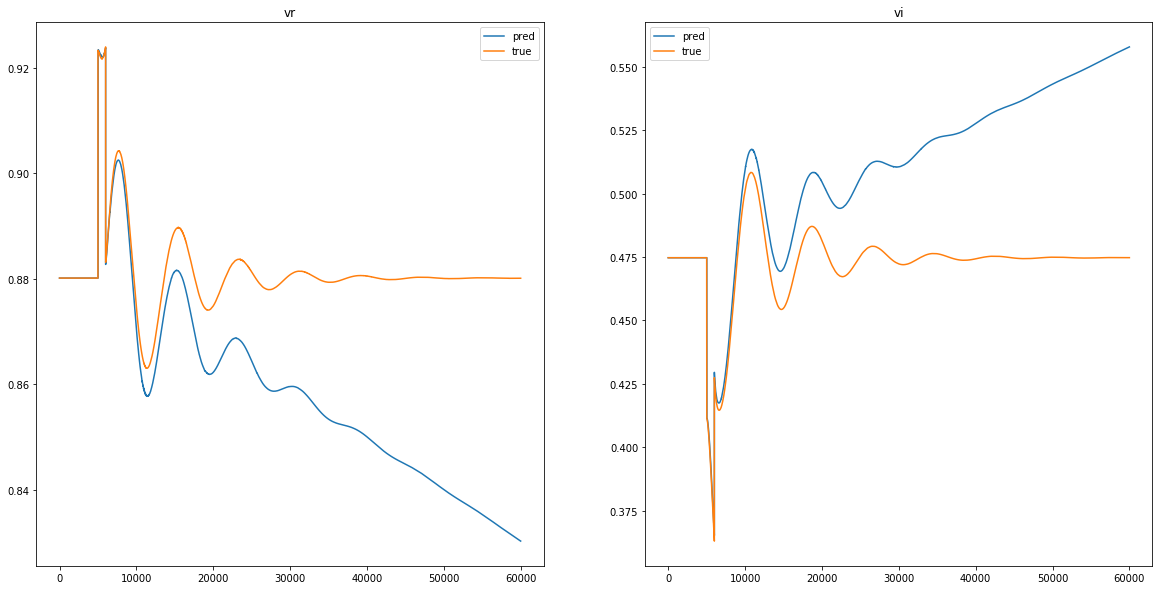

In [141]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(vvals[:, 0], label='pred')
ax[0].plot(vrefs[:, 0], label='true')
ax[0].set_title('vr')
ax[0].legend()
ax[1].plot(vvals[:, 1], label='pred')
ax[1].plot(vrefs[:, 1], label='true')
ax[1].set_title('vi')
ax[1].legend()

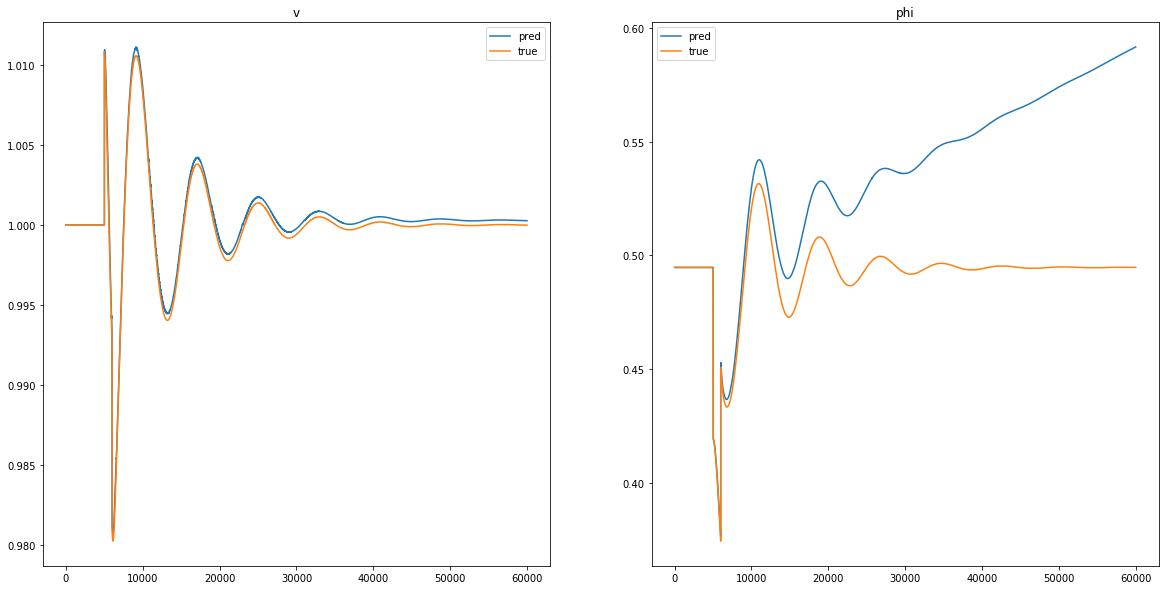

In [142]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(vvals2[:, 0], label='pred')
ax[0].plot(df['v'].values, label='true')
ax[0].set_title('v')
ax[0].legend()
ax[1].plot(vvals2[:, 1], label='pred')
ax[1].plot(df['phi'].values, label='true')
ax[1].set_title('phi')
ax[1].legend()

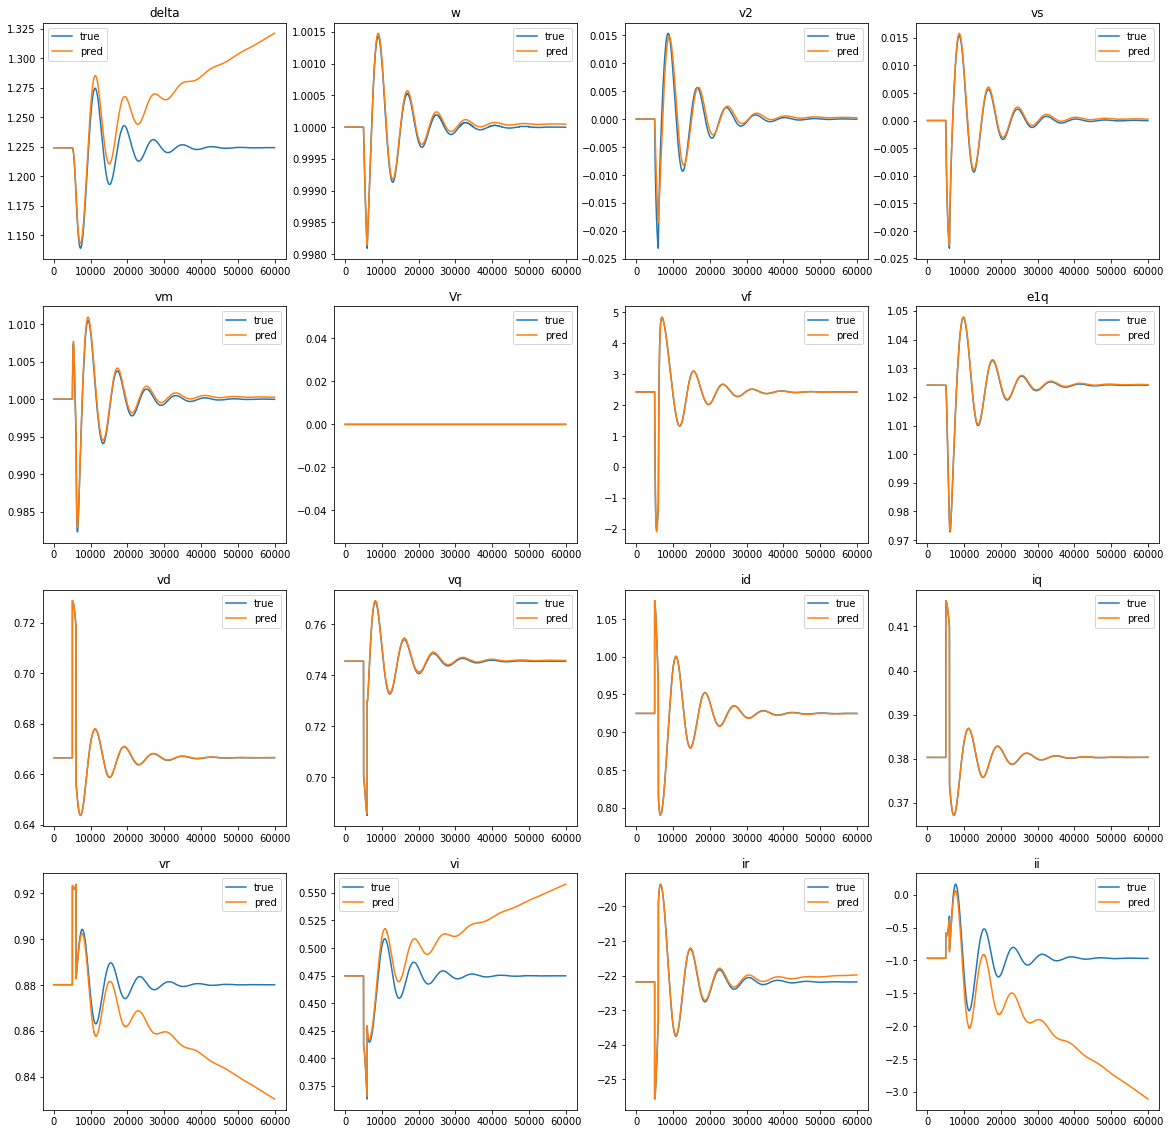

In [150]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
for truev, predv, ax, label in zip(df[['delta', 'w', 'vs', 'vs', 'vm', 'Vr', 'vf',
                               'e1q', 'vd', 'vq', 'id', 'iq', 'vr', 'vi', 'ir', 'ii']].values.T,
                            xt.T, axes.flatten(), ['delta', 'w', 'v2', 'vs', 'vm', 'Vr', 'vf',
                               'e1q', 'vd', 'vq', 'id', 'iq', 'vr', 'vi', 'ir', 'ii']):
    ax.set_title(label)
    ax.plot(truev, label='true')
    ax.plot(predv, label='pred')
    ax.legend()